In [1]:
import pandas as pd
import os
import re
from datetime import datetime, timedelta
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from image_points import *
from read_positions import read_positions
from perspective import *
import random
%matplotlib inline
import random
from helper import *
from layout import create_layout



In [2]:
df = read_positions(label_dir='../../data/labels', output_csv='positions.csv')
# df = df[(df['Camera'] == 1) | (df['Camera'] == 2) | (df['Camera'] == 4)]
df.head(11)
len(df)

2867

In [3]:
# H, mask = cv2.findHomography(IMAGE_PTS_1, MAP_PTS_1)

df_proj = pd.DataFrame(columns=['Camera', 'Date', 'X_center', 'Y_center', 'Width', 'Height'])
for index, row in df.iterrows():
    data = {}
    data['Camera'] = row['Camera']
    map_width, map_height = CAMERA_to_MAP[data['Camera']]
    H = CAMERA_to_H[data['Camera']]
    width_real = CAMERA_to_REAL[data['Camera']]
    # print(width_real)
    data['Date'] = row['Date']
    x, y, width, height = row['X_center'], row['Y_center'], row['Width'], row['Height']
    
    x, y = x*IMG_WIDTH, y*IMG_HEIGHT
    width, height = width*IMG_WIDTH, height*IMG_HEIGHT
    # print(f'x, y, w, h = {x, y, width, height}')
    x, y, width, height = shift(x, y, width, height, data['Camera'])
        
    x_proj, y_proj = transform_row(H, x, y)
    # print(polygon)  
    data['X_center'], data['Y_center'] = x_proj/map_width, y_proj/map_height
    data['Width'], data['Height'] = get_size(map_width, map_height, width_real)
    
    df_proj = pd.concat([df_proj, pd.DataFrame([data])], ignore_index=True)
print(f'LEN = {len(df_proj)}')
df_proj.head()
df_proj['Camera'].value_counts()

/tmp/ipykernel_3429863/780454095.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_proj = pd.concat([df_proj, pd.DataFrame([data])], ignore_index=True)


LEN = 2867


Camera
2    1122
7     867
1     393
6     278
4     207
Name: count, dtype: int64

In [4]:
df_proj = remove_duplicate_elephants(df_proj)
df_proj['Camera'].value_counts()

Camera
2    944
7    867
1    393
6    278
4    207
Name: count, dtype: int64

In [5]:
df_proj['Hour'] = df_proj['Date'].dt.hour
def map_to_time_window(hour):
    return f'{int(np.floor(hour / 3) * 3):02d}-{int(np.floor(hour / 3) * 3 + 3):02d}'

# Apply the function to create a time window column
df_proj['Time_Window'] = df_proj['Hour'].apply(map_to_time_window)
df_proj[['Hour', 'Time_Window']]
time_windows = df_proj['Time_Window'].unique().tolist()
time_windows.sort()
for tw in time_windows:
    print(tw, end = " ")
    print(len(df_proj[df_proj['Time_Window'] == tw]))

00-03 338
03-06 104
06-09 26
09-12 9
12-15 625
15-18 531
18-21 537
21-24 519


In [6]:
def get_heatmap_new(df, camera, size):
    df = df[df['Camera'].isin(camera)]
    # print(df['Camera'])

    # Specify the dimensions of the heatmap
    heatmap_width, heatmap_height = size

    # Initialize a blank image for the heatmap
    heatmap_img = np.zeros((heatmap_height, heatmap_width), dtype=np.float32)

    # Function to apply intensity within the bounding box area
    def apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap):
        # Calculate the bounding box in pixel coordinates
        left = int(max(0, cx - w/2))
        right = int(min(heatmap_width, cx + w/2))
        top = int(max(0, cy - h/2))
        bottom = int(min(heatmap_height, cy + h/2))

        # sigma_x = 1000/real_size
        # sigma_y = 1000/real_size
        # Apply intensity only within the bounding box, using a Gaussian distribution
        for y in range(top, bottom):
            for x in range(left, right):
                # dx = cx - x
                # dy = cy - y
                # value = np.exp(-(dx ** 2 / (2 * sigma_x ** 2) + dy ** 2 / (2 * sigma_y ** 2)))
                value = 1
                heatmap[y, x] += 1*value

    # Populate the heatmap with bounded Gaussian distribution
    for index, row in df.iterrows():
        cx, cy, w, h = row['X_center'] * heatmap_width, row['Y_center'] * heatmap_height, row['Width'] * heatmap_width, row['Height'] * heatmap_height
        apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap_img)

    # max_value = np.max(heatmap_img)
    # print(max_value)
    # heatmap_img = (heatmap_img / max_value) * 255 
    # # Normalize the heatmap
    # # cv2.normalize(heatmap_img, heatmap_img, 0, 255, norm_type=cv2.NORM_MINMAX)
    # zero_mask = (heatmap_img < 25.5) # 10 times less often
    # # Apply a colormap to create a color heatmap
    # heatmap_color = cv2.applyColorMap(np.uint8(heatmap_img), cv2.COLORMAP_JET)
    # heatmap_color[zero_mask] = (0,0,0)
    # plt.figure()
    # plt.imshow(heatmap_color[..., ::-1])  # change channels order since the YOLO work on BGR images
    # plt.show()
    return heatmap_img


1.0


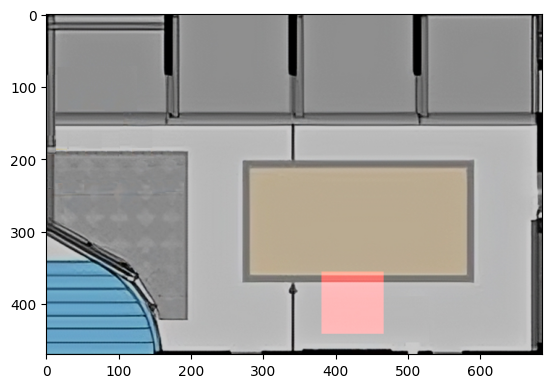

In [7]:
# Optionally, load an actual image to overlay the heatmap on
original_img = cv2.imread('maps/map12.png')
heatmap_color = get_heatmap_new(df_proj[:1], [2], CAMERA_to_MAP[2], CAMERA_to_REAL[2])
overlayed_img1 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
plt.figure()
plt.imshow(overlayed_img1[..., ::-1])  # change channels order since the YOLO work on BGR images
plt.show()


In [56]:
# Optionally, load an actual image to overlay the heatmap on
original_img = cv2.imread('maps/map12.png')
heatmap_color = get_heatmap_new(df_proj[:200], [1,2], CAMERA_to_MAP[1])
overlayed_img1 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
plt.figure()
plt.imshow(overlayed_img1[..., ::-1])  # change channels order since the YOLO work on BGR images
plt.show()

error: OpenCV(4.9.0) /io/opencv/modules/core/src/arithm.cpp:647: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


24.0


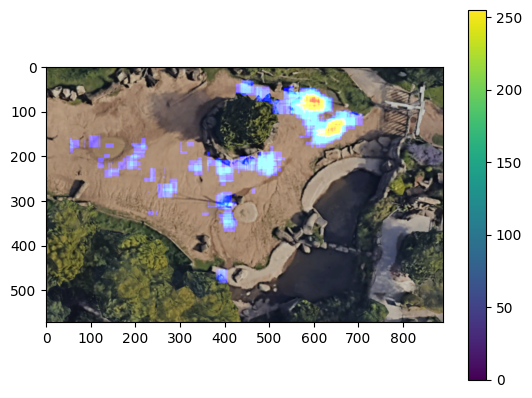

In [8]:
# Optionally, load an actual image to overlay the heatmap on
original_img = cv2.imread('maps/map6_real.png')
heatmap_color = get_heatmap_new(df_proj[:], [6], CAMERA_to_MAP[6], CAMERA_to_REAL[6])
overlayed_img6 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)

fig, ax = plt.subplots()
cax = ax.imshow(overlayed_img6[..., ::-1])  # change channels order since the YOLO work on BGR images
fig.colorbar(cax)



In [8]:
# camera_ids = [2, 4, 6, 7]  
# all_heatmaps = {}
# maxes = {}

# for tw in time_windows:
#     df = df_proj[df_proj['Time_Window'] == tw]
#     raw_heatmaps = []
#     for camera in camera_ids
    
#     raw_heatmaps = [get_heatmap_new(df, [camera], CAMERA_to_MAP[camera]) for camera in camera_ids]
#     global_max = np.max([np.max(heatmap) for heatmap in raw_heatmaps])
#     all_heatmaps[tw] = raw_heatmaps
#     maxes[tw] = global_max


SyntaxError: expected ':' (2742036433.py, line 8)

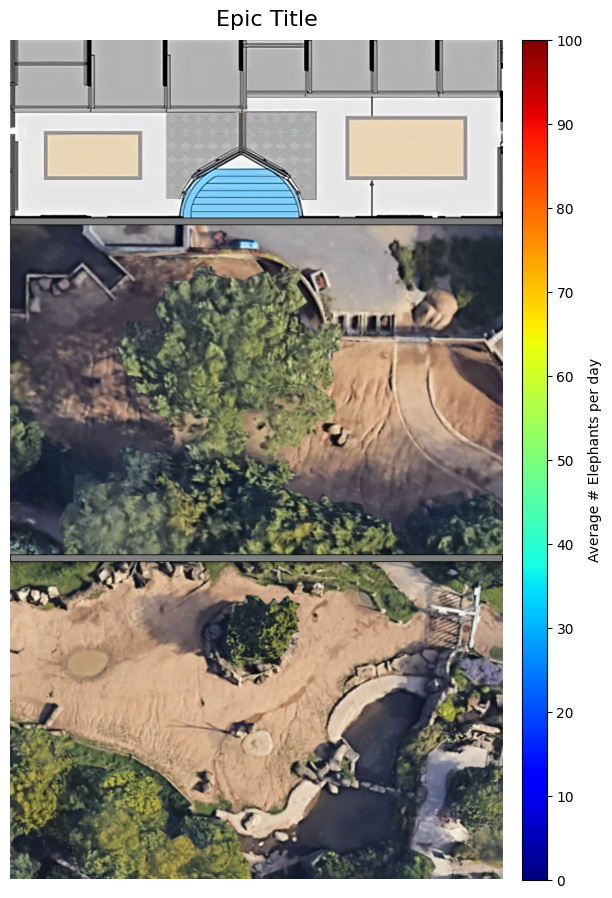

In [33]:
def add_colorbar(image, min_val, max_val, title=None, show=False):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 10),
                                   gridspec_kw={'width_ratios': [20, 1], 'wspace': 0.05})
    if title is not None:
        fig.suptitle(title, fontsize=16)
        
    # Display the image in the first subplot
    ax1.imshow(image[..., ::-1]) 
    ax1.axis('off')  # Turn off axis for image
    
    # Create a colormap and normalization instance
    cmap = mpl.cm.jet
    norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
    
    # Create the colorbar in the second subplot
    cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')
    cb1.set_label('Average # Elephants per day')
    # Set custom ticks if needed (here just showing min and max)
    tick_values = np.linspace(min_val, max_val, num=11)
    cb1.set_ticks(tick_values)
    # cb1.set_ticklabels([f'{min_val}', f'{max_val}'])
    if not show:
        plt.close()
    #fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    return fig

l = create_layout(cv2.imread('maps/map12.png'), cv2.imread('maps/map4_real.png'), cv2.imread('maps/map6_real.png'), cv2.imread('maps/map7.png'))
fig = add_colorbar(l, 0, 100, 'Epic Title', show=True)
# fig.savefig('x.png', bbox_inches='tight')

# fig.show()


In [31]:
def create_full_heatmap(df, save_path, days_interval=10, min_scale=20, title=None):
    camera_ids = [2, 4, 6, 7]
    raw_heatmaps = []
    heatmap_1 = get_heatmap_new(df, [1,2], CAMERA_to_MAP[1])
    raw_heatmaps.append(heatmap_1)
    for camera in camera_ids[1:]:
        raw_heatmaps.append(get_heatmap_new(df, [camera], CAMERA_to_MAP[camera]))
    global_max = np.max([np.max(heatmap) for heatmap in raw_heatmaps])

    def normalize_and_apply_colormap(heatmap, global_max, min_scale=min_scale):
        # Scale heatmap values based on global_max directly
        heatmap_scaled = (heatmap / global_max) * 255 
        heatmap_scaled = np.clip(heatmap_scaled, 0, 255).astype(np.uint8)  # Ensure values are within byte range
        zero_mask = (heatmap_scaled < 255/min_scale)

        heatmap_color = cv2.applyColorMap(heatmap_scaled, cv2.COLORMAP_JET)
        heatmap_color[zero_mask] = (0,0,0)
        return heatmap_color

    normalized_heatmaps = [normalize_and_apply_colormap(heatmap, global_max) for heatmap in raw_heatmaps]

    
    original_img = cv2.imread(CAMERA_to_PATH[1])
    # plot_images(original_img)
    heatmap_color = normalized_heatmaps[0]
    overlayed_img1 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
    
    original_img = cv2.imread(CAMERA_to_PATH[7])
    heatmap_color = normalized_heatmaps[3]
    overlayed_img7 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
    
    original_img = cv2.imread(CAMERA_to_PATH[6])
    heatmap_color = normalized_heatmaps[2]
    overlayed_img6 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
    
    original_img = cv2.imread(CAMERA_to_PATH[4])
    heatmap_color = normalized_heatmaps[1]
    overlayed_img4 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)

    final_layout = create_layout(overlayed_img1, overlayed_img4, overlayed_img6, overlayed_img7)

    max_per_day = global_max/days_interval
    
    fig = add_colorbar(final_layout, max_per_day/min_scale, max_per_day, title)
    fig.savefig(save_path, bbox_inches='tight')
    
create_full_heatmap(df=df_proj[:], save_path='he.png')

/tmp/ipykernel_3429863/2113401749.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


In [32]:
for tw in time_windows:
    df = df_proj[df_proj['Time_Window'] == tw]
    create_full_heatmap(df=df, save_path=f'he{tw}.png', title=tw)
    

/tmp/ipykernel_3429863/2113401749.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3429863/2113401749.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3429863/2113401749.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3429863/2113401749.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3429863/2113401749.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3429863/2113401749.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so

True

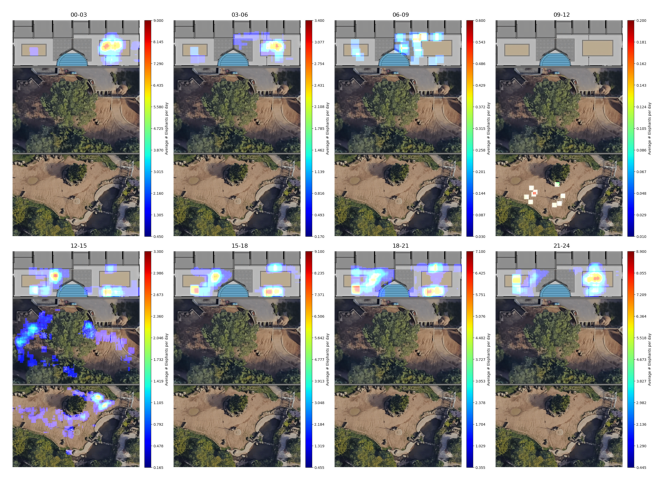

In [37]:
image_paths = [f"he{x}.png" for x in time_windows]
images = [cv2.imread(path) for path in image_paths]
rows = [cv2.hconcat(images[i:i+4]) for i in range(0, 8, 4)]
# Vertically concatenate the rows to form the final grid
stacked_image = cv2.vconcat(rows)
plot_images(stacked_image)
cv2.imwrite('he_all.png', stacked_image)

In [55]:
# Optionally, load an actual image to overlay the heatmap on
def one_heatmap(df, camera):
    original_img = cv2.imread(CAMERA_to_PATH[camera])
    heatmap_color = get_heatmap_new(df, [camera], CAMERA_to_MAP[camera])
    overlayed_img = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
    plt.figure()
    plt.imshow(overlayed_img4[..., ::-1])  # change channels order since the YOLO work on BGR images
    plt.show()



TypeError: get_heatmap_new() takes 3 positional arguments but 4 were given

8.0


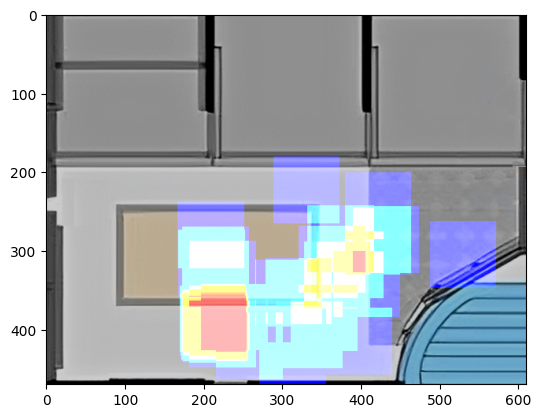

In [10]:
# Optionally, load an actual image to overlay the heatmap on
original_img = cv2.imread('maps/map7.png')
heatmap_color = get_heatmap_new(df_proj[:100], [7], CAMERA_to_MAP[7], CAMERA_to_REAL[7])
overlayed_img7 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
plt.figure()
plt.imshow(overlayed_img7[..., ::-1])  # change channels order since the YOLO work on BGR images
plt.show()


In [21]:
def plot_images(*imgs, titles=[], channels='bgr', normalize=False, ticks_off=True, title_size=32, width=30, height=30):
    assert channels.lower() in ['bgr', 'rgb', 'mono'], 'Possible values for channels are: bgr, rgb or mono!'

    #     f = plt.figure(figsize=(30, 20))
    width_def = width
    height_def = height

    width = math.ceil(math.sqrt(len(imgs)))
    height = math.ceil(len(imgs) / width)
    height_def = height_def / 5 * width
    if height_def > 65:
        height_def = 65

    f = plt.figure(figsize=(width_def, height_def))
    for i, img in enumerate(imgs, 1):
        ax = f.add_subplot(height, width, i)
        if ticks_off:
            ax.axis('off')

        if len(titles) != 0:
            if len(imgs) != len(titles):
                print('WARNING titles length is not the same as images length!')

            try:
                ax.set_title(str(titles[i - 1]), fontdict={'fontsize': title_size, 'fontweight': 'medium'})
            except:
                pass

        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))



x = create_layout(overlayed_img1, overlayed_img4 , overlayed_img6, overlayed_img7)
plot_images(x, titles=['Yay'], width=60, height=60)


NameError: name 'overlayed_img1' is not defined